In this tutorial, we will introduce readers to how to write new ```pcells```.
Each layout class in ```pirel``` is derived by ```pt.LayoutPart```, which defines common methods such as ```view()```, ```get_params()``` , ```set_params()``` etc. 

# Define A ```pirel``` pcell 


In [1]:
import pirel.tools as pt
import pirel.pcells as pc


class NewLayoutClass(pt.LayoutPart):
    
    pass

o=NewLayoutClass(name='New Born Class')

o


TypeError: Can't instantiate abstract class NewLayoutClass with abstract method draw

The previous code fails because, as a minimum, each class derived from ```LayoutPart``` needs to define an implementation of the abstract method ```draw()```:

In [3]:

class NewerLayoutClass(pt.LayoutPart):
    
    def draw(self):
            
        from phidl.geometry import ring
        
        return ring()
    
    pass

o=NewerLayoutClass(name='New Born Class')

o


Name      New Born Class
Type    NewerLayoutClass

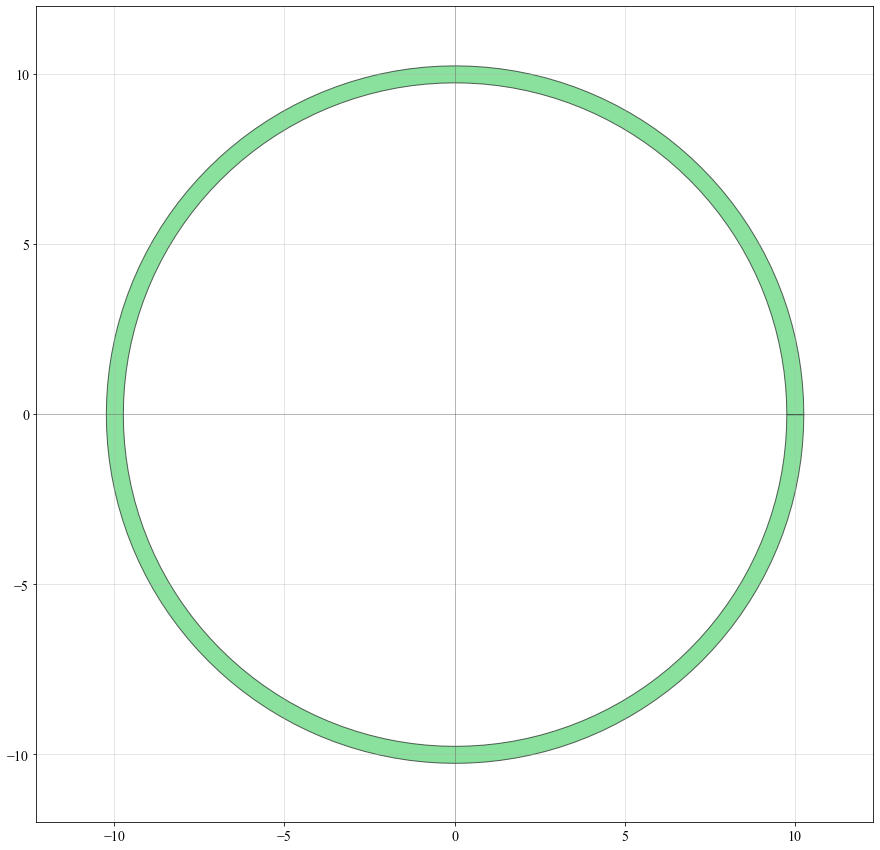

In [4]:
o.view()

# Add layout parameters to a ```pirel``` pcell

Classes in ```pirel``` can have layout parameters.

Let's imagine we want to define a class with an ```pc.IDT``` component and a ring on a layer ```ring_layer``` with inner diameter ```inner_diameter``` and outer diameter ```outer_diameter```.

To instantiate parameter, we use the ```pt.LayoutParamInterface()``` descriptor.

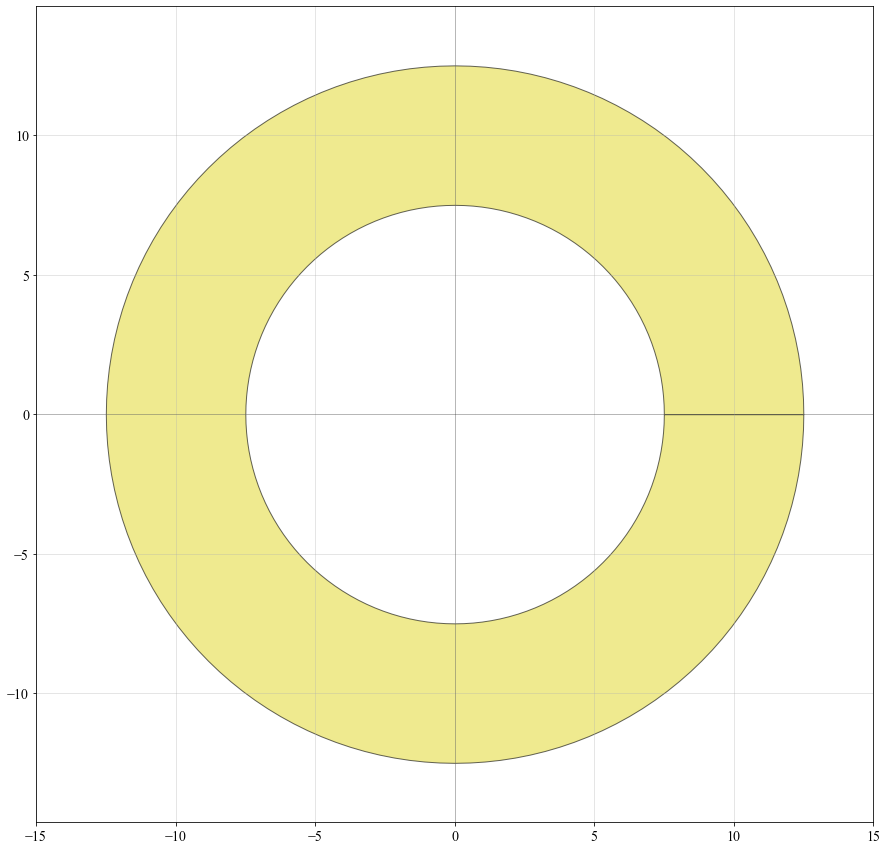

In [7]:
from pirel.tools import LayoutParamInterface

class PirelRing(pt.LayoutPart):
        
    ring_layer=LayoutParamInterface()
    
    inner_diameter=LayoutParamInterface()
    
    outer_diameter=LayoutParamInterface()
    
    def __init__(self,*a,**k):
        
        super().__init__(*a,**k)
        self.ring_layer=3
        self.inner_diameter=20.0
        self.outer_diameter=30.0
        
    def draw(self):

        from phidl.geometry import ring
        
        return ring(radius=self.inner_diameter/2,width=(self.outer_diameter-self.inner_diameter)/2,layer=self.ring_layer)

o=PirelRing('newring')
o.view()

Note that as long as instance parameters are initialized in ```__init__``` they are automatically included in the list of instance parameters (gettable through ```get_params()```, settable via ```set_params()```).

The set value of each ```LayoutParamInterface()``` is actually used to validate assignment: 

In [8]:
o.ring_layer='a' #throws error

ValueError: Cannot assign type str to RingLayer

Since an _int_ was assigned to _ring_layer_ in __init__, this parameter cannot be set to something that is not an _int_

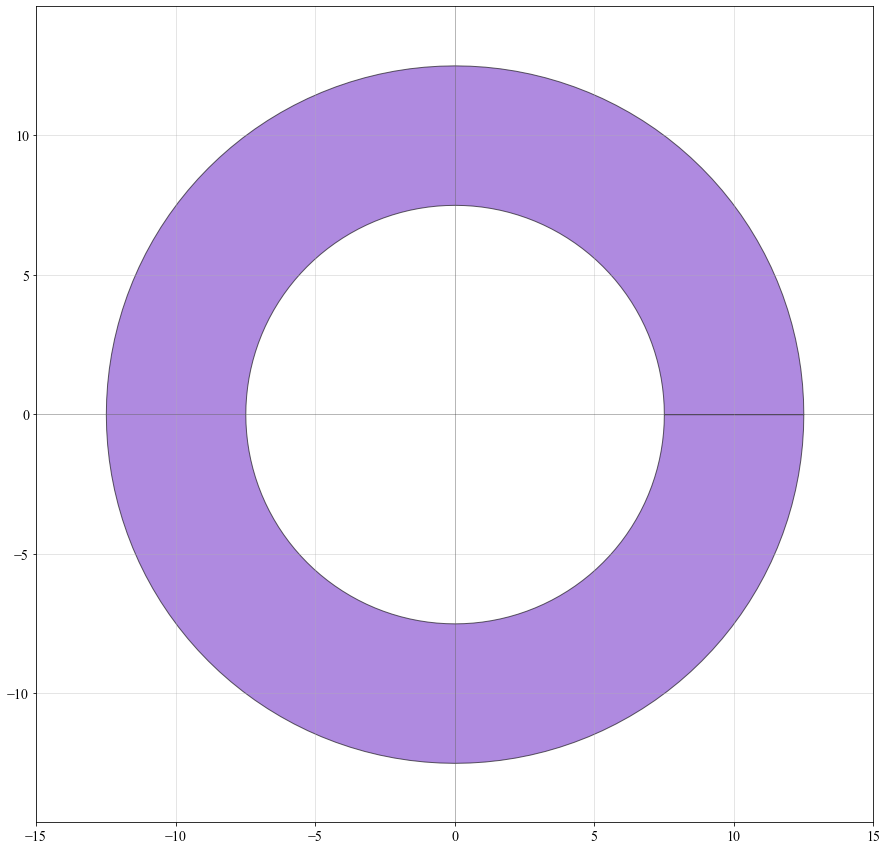

In [9]:
o.ring_layer=4 #no problem!
o.view()

Also note that instance attributes can be accessed in _snake_case_style_, while when exported they are accessed in _UpperCaseStyle_

# Define components as parts of a ```pcell``` 

```components``` parameter are passed to the instance as well, by overriding the static ```get_components()``` method.

```get_components()``` returns a dict : each ```key``` specifies the component tag to prepend to the instance, each ```value``` specifies the class of the component to be included in the class.

In [10]:

class IDTRing(PirelRing):
    
    @staticmethod
    
    def get_components():
    
        return {'IDT':pc.IDT}
    
    pass

n=IDTRing()
n

IDTName                defaultIDT
IDTLength                   200.0
IDTPitch                     20.0
IDTYOffset                   10.0
IDTCoverage                   0.7
IDTN                            4
IDTActiveAreaMargin           0.5
Name                      default
InnerDiameter                20.0
OuterDiameter                30.0
Type                      IDTRing

Note that ```IDTRing``` has all the parameters of ```PirelRing``` but also the parameters of ```pc.IDT```, appended to the identifier ```IDT``` which was the ```pc.IDT``` key in ```get_components()```.

```IDTRing``` has also an attribute that contains an instance of ```pc.IDT```, and can be accessed by lowercasing the key ```IDT``` to ```idt```: 

In [11]:
n.idt

Name                defaultIDT
Length                   200.0
Pitch                     20.0
YOffset                   10.0
Coverage                   0.7
N                            4
ActiveAreaMargin           0.5
Type                       IDT

In this way, ```IDTRing``` can access all methods of ```IDT```.

For example, ```IDTRing``` can redefine the ```draw()``` method so to reuse the ```draw()``` of its ```components``` and its parents.

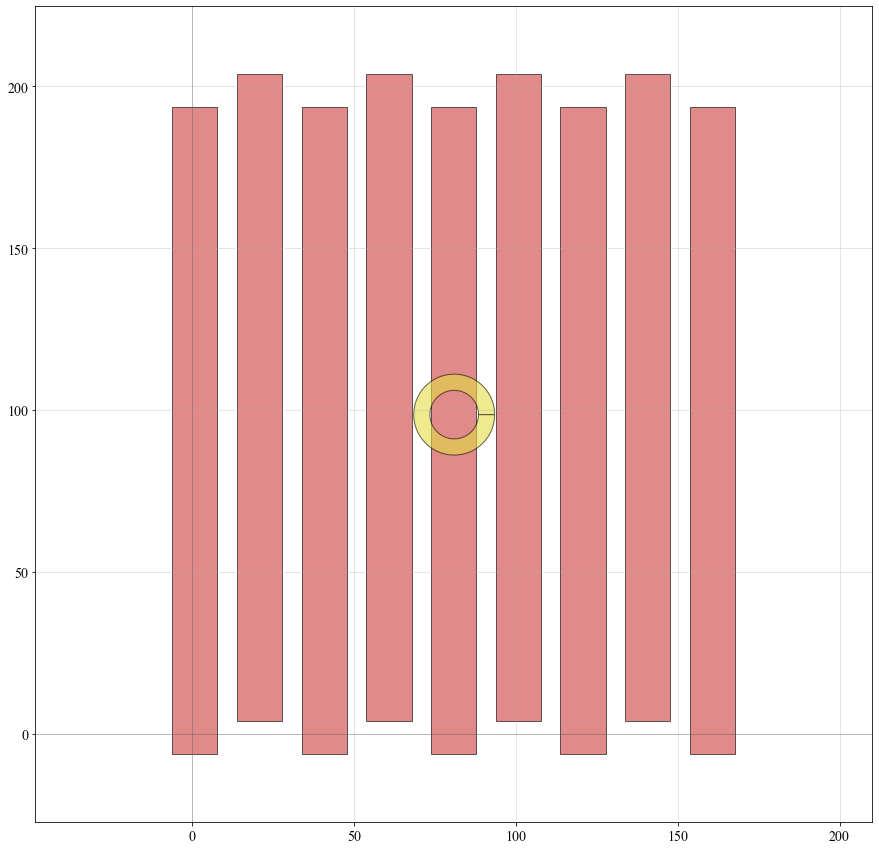

In [12]:

class IDTRing(PirelRing):
        
        
    def draw(self):
        
        from phidl.device_layout import Group
        from phidl.device_layout import Device
        
        ring_cell=PirelRing.draw(self)
        
        idt_cell=self.idt.draw()
        
        out_cell=Device(self.name)
        
        ring_ref=out_cell<<ring_cell
        
        idt_ref=out_cell<<idt_cell
        
        g=Group([ring_ref,idt_ref])
        
        g.align(alignment='y')
        g.align(alignment='x')
         
        out_cell.flatten()
        
        return out_cell
    
    @staticmethod
    
    def get_components():
    
        return {'IDT':pc.IDT}
    
    pass

n=IDTRing()

n.view()


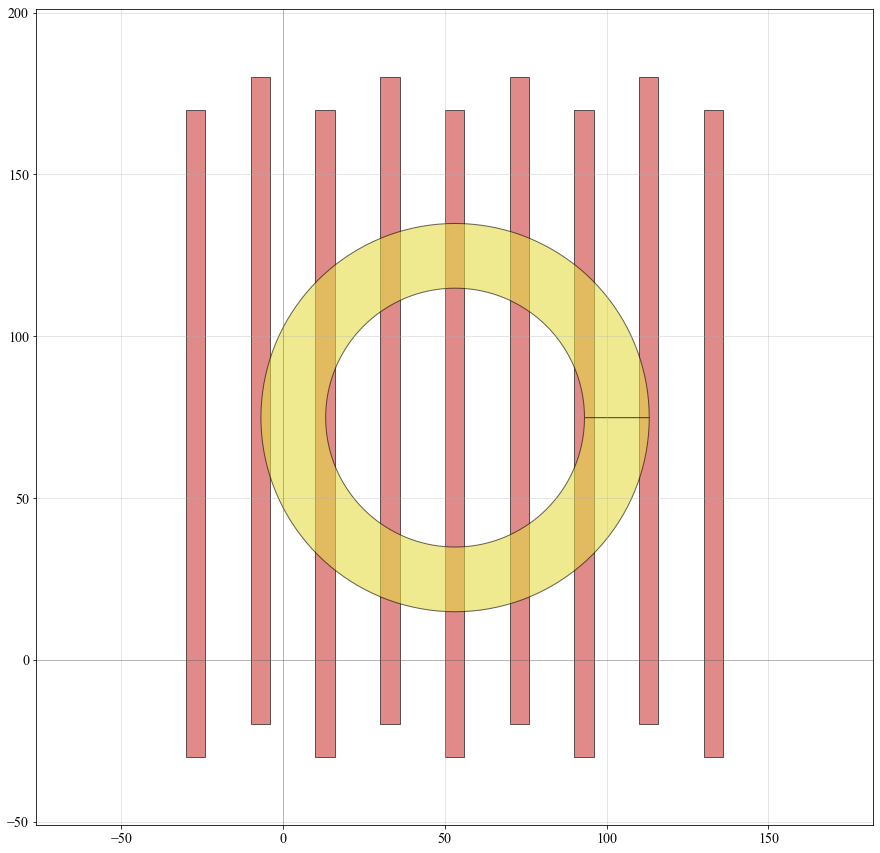

In [13]:
n.inner_diameter=100.0
n.outer_diameter=140.0

n_params=n.get_params()

n_params['IDTCoverage']=0.3

n.set_params(n_params)
n.view()

In the previous, we used both the _snake_case_ attribute to access the parameter and the ```set_params/get_params``` methods, with same outcome.